In [2]:
%pip install optuna scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


# Import library


In [3]:
import numpy as np
import pandas as pd
import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import XGBClassifier

import optuna

import time
import itertools

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set(style="whitegrid")
plt.style.use("ggplot")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing and import


In [5]:
train = pd.read_csv("/content/drive/MyDrive/ML project/nsl-kdd/KDDTrain+.txt")


In [6]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])
train.columns = columns

In [7]:
total = train.shape[0]
print(total)
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

125972


No missing data

In [8]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


In [9]:
train.loc[train['outcome'] == "normal", "outcome"] = 'normal'
train.loc[train['outcome'] != 'normal', "outcome"] = 'attack'

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

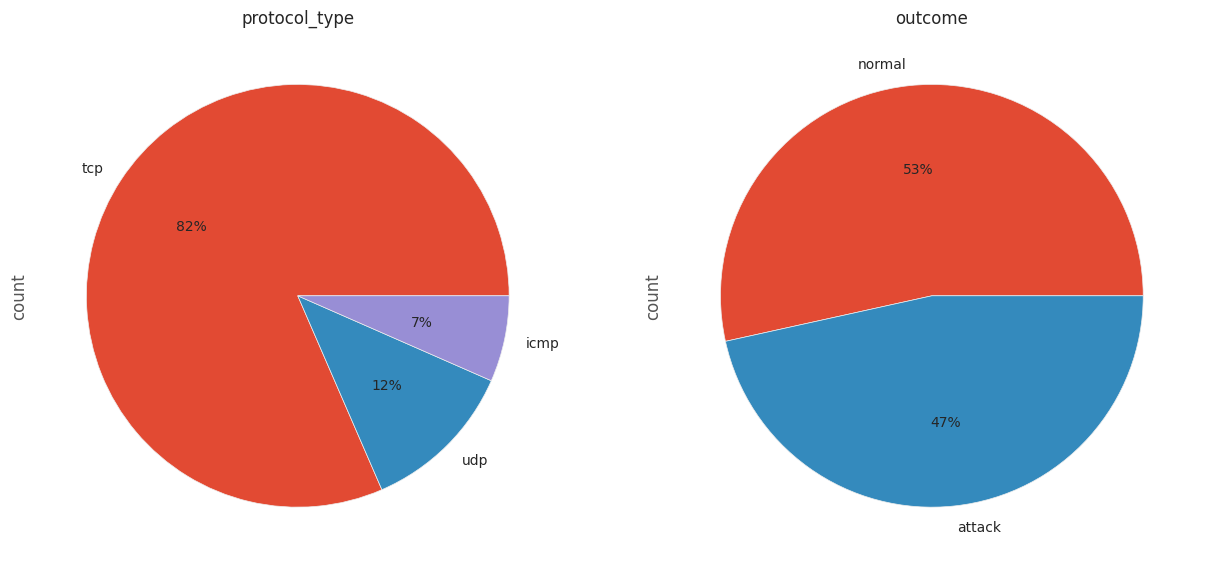

In [11]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()
pie_plot(train, ['protocol_type', 'outcome'], 1, 2)

In [12]:
encoding_dict = {"protocol_type":LabelEncoder(),
                 "service":LabelEncoder(),
                 "flag":LabelEncoder()}
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)

In [13]:
print(train.dtypes)

duration                         int64
protocol_type                    int64
service                          int64
flag                             int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

<Axes: >

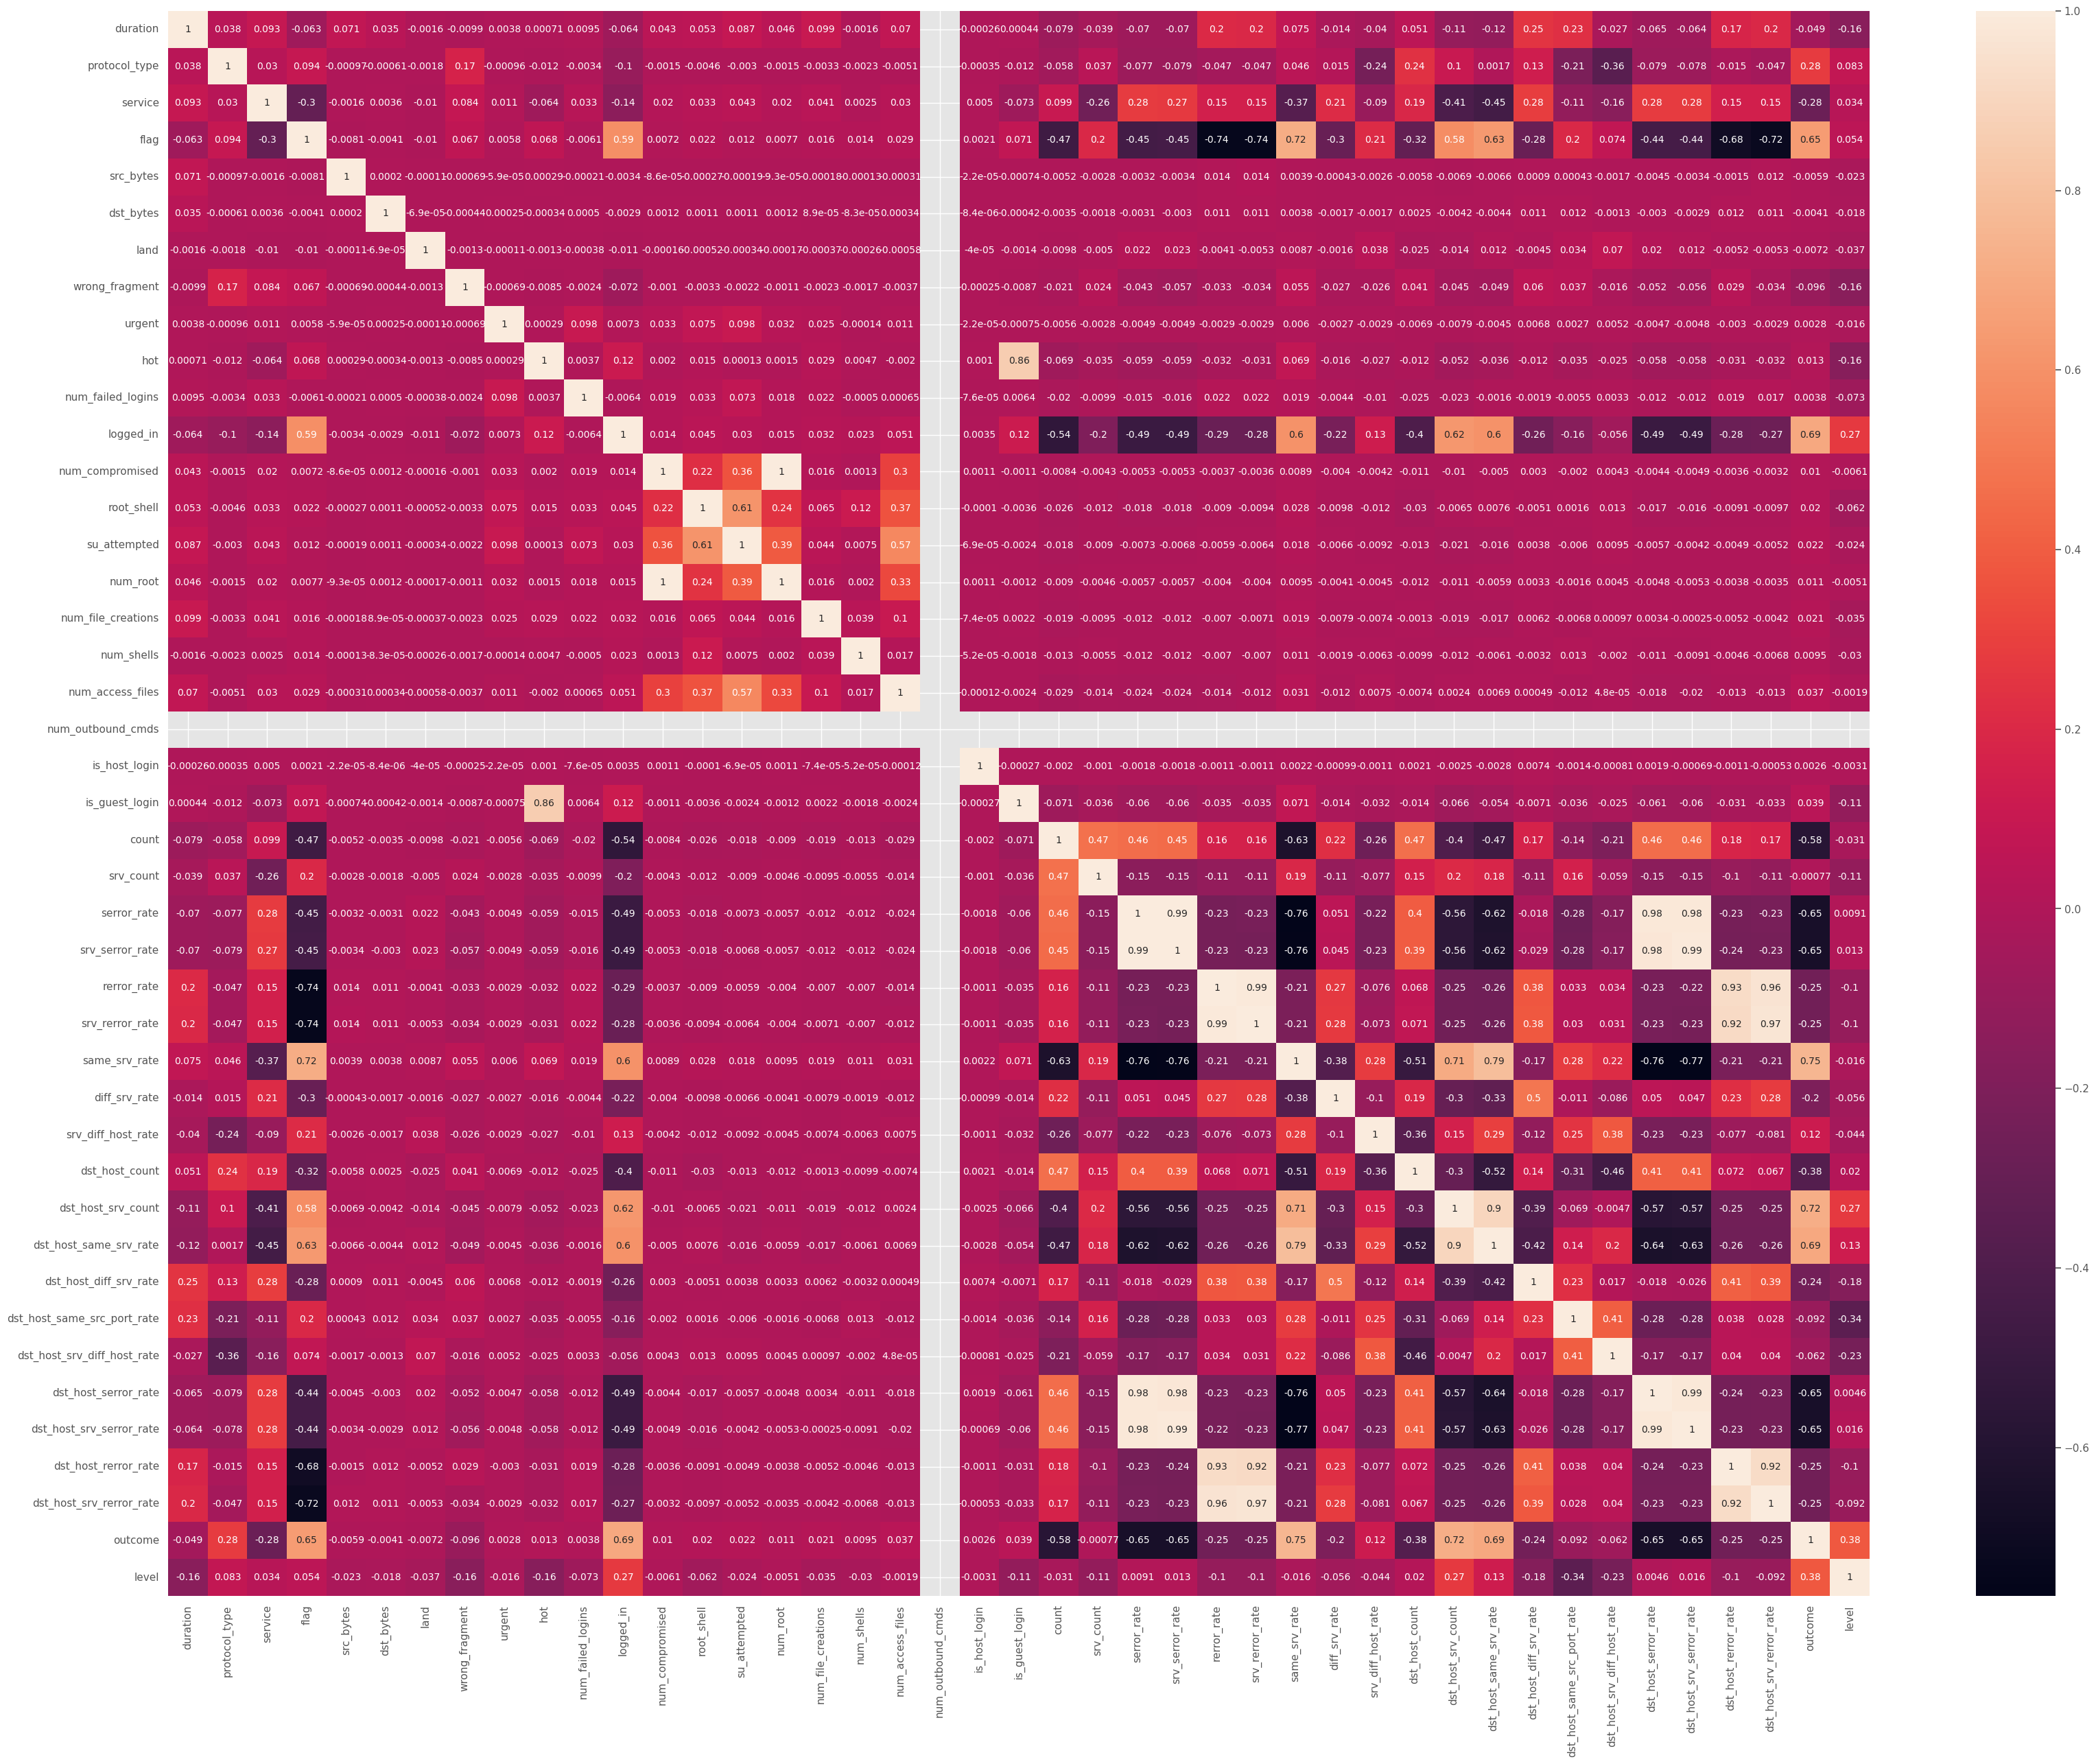

In [14]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(), annot=True)

# Feature selection

In [15]:
X_train = train.drop(['outcome','level'], axis=1)
Y_train = train['outcome']
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=20)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'hot',
 'logged_in',
 'count',
 'srv_count',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_srv_serror_rate',
 'dst_host_srv_rerror_rate']

## Applying PCA

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#'class' is the target variable
X_train = train.drop(['outcome','level'], axis=1)
Y_train = train['outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA()  # Set the number of components to keep
X_pca = pca.fit_transform(X_scaled)

# Check the shape of X_pca and Y_train
print("Shape of X_pca:", X_pca.shape)
print("Shape of Y_train:", Y_train.shape)

# Make sure Y_train is a 1D array
if Y_train.ndim > 1:
    Y_train = Y_train.ravel()

# Train-test split of PCA-transformed data
X_train_pca, X_test_pca, Y_train_pca, Y_test = train_test_split(X_pca, Y_train, test_size=0.3, random_state=42)

# Display the shapes of the resulting datasets
print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("Y_train shape:", Y_train_pca.shape)
print("Y_test shape:", Y_test.shape)


Shape of X_pca: (125972, 41)
Shape of Y_train: (125972,)
X_train_pca shape: (88180, 41)
X_test_pca shape: (37792, 41)
Y_train shape: (88180,)
Y_test shape: (37792,)


## Apply RFE selected features

In [17]:
X_train = X_train[selected_features]

In [18]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

# Algorithm implementation


In [19]:
model_details=[]

##  K Nearest Neightbors

In [20]:
def KNN_tune(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)

    start_time = time.time()
    classifier_obj.fit(x_train, y_train)
    training_time = time.time() - start_time

    accuracy = classifier_obj.score(x_test, y_test)
    print(f"Trial: {trial.number}, KNN_n_neighbors: {n_neighbors}, Accuracy: {accuracy:.4f}, Training Time: {training_time:.4f} seconds")

    return accuracy

# Conduct hyperparameter optimization
study_KNN = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner())
study_KNN.optimize(KNN_tune, n_trials=10)

# Train final model with best parameters
best_params = study_KNN.best_trial.params
KNN_model = KNeighborsClassifier(n_neighbors=best_params['KNN_n_neighbors'])

start_time = time.time()
KNN_model.fit(x_train, y_train)
training_time_final = time.time() - start_time

# Predict on the test set
y_test_pred = KNN_model.predict(x_test)

# Generate the classification report and confusion matrix
class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Extract test metrics
test_precision = class_report['macro avg']['precision']
test_recall = class_report['macro avg']['recall']
test_f1 = class_report['macro avg']['f1-score']
accuracy = accuracy_score(y_test, y_test_pred)

# Displaying Results
print(f"\nTraining Time: {training_time_final:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")

# Storing results in a dictionary
knn_results = {
    'Model': 'KNN',
    'Training Time (s)': round(training_time_final, 4),
    'Accuracy':round(accuracy,4),
    'Test Precision': round(test_precision, 4),
    'Test Recall': round(test_recall, 4),
    'Test F1 Score': round(test_f1, 4)
}

# Add knn_results to model details if needed
model_details.append(knn_results)


Trial: 0, KNN_n_neighbors: 12, Accuracy: 0.9934, Training Time: 0.0068 seconds
Trial: 1, KNN_n_neighbors: 7, Accuracy: 0.9943, Training Time: 0.0045 seconds
Trial: 2, KNN_n_neighbors: 4, Accuracy: 0.9953, Training Time: 0.0038 seconds
Trial: 3, KNN_n_neighbors: 4, Accuracy: 0.9953, Training Time: 0.0038 seconds
Trial: 4, KNN_n_neighbors: 2, Accuracy: 0.9957, Training Time: 0.0036 seconds
Trial: 5, KNN_n_neighbors: 8, Accuracy: 0.9940, Training Time: 0.0042 seconds
Trial: 6, KNN_n_neighbors: 16, Accuracy: 0.9930, Training Time: 0.0038 seconds
Trial: 7, KNN_n_neighbors: 12, Accuracy: 0.9934, Training Time: 0.0039 seconds
Trial: 8, KNN_n_neighbors: 16, Accuracy: 0.9930, Training Time: 0.0040 seconds
Trial: 9, KNN_n_neighbors: 12, Accuracy: 0.9934, Training Time: 0.0038 seconds

Training Time: 0.0040 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     17710
           1       1.00      0.99      1.00     2008

## Logistic Regression

In [21]:
lg_model = LogisticRegression(random_state=2)

start_time = time.time()
lg_model.fit(x_train, y_train)
lg_training_time = time.time() - start_time

y_test_pred = lg_model.predict(x_test)

class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Extract test metrics
test_precision = class_report['macro avg']['precision']
test_recall = class_report['macro avg']['recall']
test_f1 = class_report['macro avg']['f1-score']
accuracy = accuracy_score(y_test, y_test_pred)

# Displaying Results
print(f"\nTraining Time (final model): {training_time_final:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")

# Storing results in a dictionary
lg_result = {
    'Model': 'Logistic Regression',
    'Training Time (s)': round(training_time_final, 4),
    'Accuracy':round(accuracy,4),
    'Test Precision': round(test_precision, 4),
    'Test Recall': round(test_recall, 4),
    'Test F1 Score': round(test_f1, 4)
}

# Add lg_result to model details if needed
model_details.append(lg_result)


Training Time (final model): 0.0040 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     17710
           1       0.94      0.95      0.95     20082

    accuracy                           0.94     37792
   macro avg       0.94      0.94      0.94     37792
weighted avg       0.94      0.94      0.94     37792

Confusion Matrix:
[[16445  1265]
 [  949 19133]]
Accuracy: 0.9414161727349704


## Decision Tree

In [22]:
def dt_tune(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10)

    classifier_obj = DecisionTreeClassifier(max_features=dt_max_features, max_depth=dt_max_depth)
    classifier_obj.fit(x_train, y_train)

    # Evaluate accuracy on the test set
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

# Conduct hyperparameter optimization
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(dt_tune, n_trials=30)

# Train final model with best parameters
best_params = study_dt.best_trial.params
dt = DecisionTreeClassifier(max_features=best_params['dt_max_features'], max_depth=best_params['dt_max_depth'])

# Train the model and measure training time
start_time = time.time()
dt.fit(x_train, y_train)
dt_training_time = time.time() - start_time

# Predict on the test set
dt_y_test_pred = dt.predict(x_test)

# Generate the classification report and confusion matrix
class_report = classification_report(y_test, dt_y_test_pred, output_dict=True)
dt_conf_matrix = confusion_matrix(y_test, dt_y_test_pred)

# Extract test metrics
test_precision = class_report['macro avg']['precision']
test_recall = class_report['macro avg']['recall']
test_f1 = class_report['macro avg']['f1-score']
acc=accuracy_score(y_test,dt_y_test_pred)

# Displaying Results
print(f"\nTraining Time (final model): {dt_training_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, dt_y_test_pred))
print("Confusion Matrix:")
print(dt_conf_matrix)
print("Accuracy:")
print(acc)

# Storing results in a dictionary
dt_results = {
    'Model': 'Decision Tree',
    'Training Time (s)': round(dt_training_time, 4),
    'Accuracy':round(acc,4),
    'Test Precision': round(test_precision, 4),
    'Test Recall': round(test_recall, 4),
    'Test F1 Score': round(test_f1, 4)
}

# Append results to model details if needed
model_details.append(dt_results)



Training Time (final model): 0.1585 seconds
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17710
           1       1.00      1.00      1.00     20082

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

Confusion Matrix:
[[17663    47]
 [   45 20037]]
Accuracy:
0.9975656223539373


In [23]:
def dt_tune(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10)

    classifier_obj = DecisionTreeClassifier(max_features=dt_max_features, max_depth=dt_max_depth)
    classifier_obj.fit(X_train_pca, Y_train_pca)

    # Evaluate accuracy on the test set
    accuracy = classifier_obj.score(X_test_pca, Y_test)
    return accuracy

# Create and optimize study
study_dt = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner())
study_dt.optimize(dt_tune, n_trials=30)

# Define best model using Optuna's best hyperparameters
best_params = study_dt.best_trial.params
dt = DecisionTreeClassifier(max_features=best_params['dt_max_features'], max_depth=best_params['dt_max_depth'])

# Train the model and measure training time
start_time = time.time()
dt.fit(X_train_pca, Y_train_pca)
dt_training_time = time.time() - start_time

# Predict on the test set
dt_y_test_pred = dt.predict(X_test_pca)

# Generate the classification report and confusion matrix for test data
class_report = classification_report(Y_test, dt_y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(Y_test, dt_y_test_pred)

# Extract test metrics
test_precision = class_report['macro avg']['precision']
test_recall = class_report['macro avg']['recall']
test_f1 = class_report['macro avg']['f1-score']
acc=accuracy_score(Y_test,dt_y_test_pred)

# Displaying Results
print(f"\nTraining Time (final model): {dt_training_time:.4f} seconds")
print("Classification Report:")
print(classification_report(Y_test, dt_y_test_pred))
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:")
print(acc)

# Store results in dictionary
dt_results = {
    'Model': 'Decision Tree (PCA)',
    'Training Time (s)': round(dt_training_time, 4),
    'Accuracy':round(acc,4),
    'Test Precision': round(test_precision, 4),
    'Test Recall': round(test_recall, 4),
    'Test F1 Score': round(test_f1, 4)
}

# Append results to model details
model_details.append(dt_results)



Training Time (final model): 1.7506 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17778
           1       1.00      0.99      0.99     20014

    accuracy                           0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792

Confusion Matrix:
[[17687    91]
 [  124 19890]]
Accuracy:
0.9943109652836579


## Random Forest

In [24]:
def rf_tune(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20)

    classifier_obj = RandomForestClassifier(
        max_features=rf_max_features,
        max_depth=rf_max_depth,
        n_estimators=rf_n_estimators
    )
    classifier_obj.fit(x_train, y_train)

    # Evaluate accuracy on the test set
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

# Create and optimize study
study_rf = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner())
study_rf.optimize(rf_tune, n_trials=30)

# Define best model using Optuna's best hyperparameters
best_params = study_rf.best_trial.params
rf = RandomForestClassifier(
    max_features=best_params['rf_max_features'],
    max_depth=best_params['rf_max_depth'],
    n_estimators=best_params['rf_n_estimators']
)

# Train the model and measure training time
start_time = time.time()
rf.fit(x_train, y_train)
rf_training_time = time.time() - start_time

# Predict on the test set
rf_y_test_pred = rf.predict(x_test)

# Generate the classification report and confusion matrix for test data
class_report = classification_report(y_test, rf_y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, rf_y_test_pred)
acc=accuracy_score(y_test,rf_y_test_pred)
# Extract test metrics
test_precision = class_report['macro avg']['precision']
test_recall = class_report['macro avg']['recall']
test_f1 = class_report['macro avg']['f1-score']

# Displaying Results
print(f"\nTraining Time (final model): {rf_training_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, rf_y_test_pred))
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:",acc)
# Store results in dictionary
rf_results = {
    'Model': 'Random Forest',
    'Training Time (s)': round(rf_training_time, 4),
    'Accuracy':round(acc,4),
    'Test Precision': round(test_precision, 4),
    'Test Recall': round(test_recall, 4),
    'Test F1 Score': round(test_f1, 4)
}

# Append results to model details
model_details.append(rf_results)



Training Time (final model): 2.1267 seconds
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17710
           1       1.00      1.00      1.00     20082

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

Confusion Matrix:
[[17682    28]
 [   19 20063]]
Accuracy: 0.998756350550381


In [25]:
def rf_tune_pca(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20)

    classifier_obj = RandomForestClassifier(
        max_features=rf_max_features,
        max_depth=rf_max_depth,
        n_estimators=rf_n_estimators
    )
    classifier_obj.fit(X_train_pca, Y_train_pca)

    # Evaluate accuracy on the test set
    accuracy = classifier_obj.score(X_test_pca, Y_test)
    return accuracy

# Create and optimize study
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(rf_tune_pca, n_trials=30)

print("Best Trial:", study_rf.best_trial)

# Define best model using Optuna's best hyperparameters
best_params = study_rf.best_trial.params
rf = RandomForestClassifier(
    max_features=best_params['rf_max_features'],
    max_depth=best_params['rf_max_depth'],
    n_estimators=best_params['rf_n_estimators']
)

# Train the model and measure training time
start_time = time.time()
rf.fit(X_train_pca, Y_train_pca)
rf_training_time = time.time() - start_time

# Predict on the test set
rf_y_test_pred = rf.predict(X_test_pca)

# Generate the classification report and confusion matrix for test data
class_report = classification_report(Y_test, rf_y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(Y_test, rf_y_test_pred)

# Extract test metrics
test_precision = class_report['macro avg']['precision']
test_recall = class_report['macro avg']['recall']
test_f1 = class_report['macro avg']['f1-score']
acc=accuracy_score(Y_test,rf_y_test_pred)

# Display Results
print(f"\nTraining Time (final model): {rf_training_time:.4f} seconds")
print("Classification Report :")
print(classification_report(Y_test, rf_y_test_pred))
print("Confusion Matrix :")
print(conf_matrix)
print("Accuracy:",acc)

# Store results in dictionary
rf_results = {
    'Model': 'Random Forest (PCA)',
    'Training Time (s)': round(rf_training_time, 4),
    'Accuracy':round(acc,4),
    'Test Precision': round(test_precision, 4),
    'Test Recall': round(test_recall, 4),
    'Test F1 Score': round(test_f1, 4)
}

# Append results to model details
model_details.append(rf_results)


Best Trial: FrozenTrial(number=5, state=TrialState.COMPLETE, values=[0.9969305673158341], datetime_start=datetime.datetime(2024, 11, 16, 7, 30, 2, 669172), datetime_complete=datetime.datetime(2024, 11, 16, 7, 30, 14, 337309), params={'rf_max_depth': 31, 'rf_max_features': 7, 'rf_n_estimators': 12}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=5, value=None)

Training Time (final model): 10.8199 seconds
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17778
           1       1.00      1.00      1.00     20014

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     3779

## SVM


In [26]:
# Initialize list to store SVM results
SVM_details = []

# Define a function to evaluate the SVM model with different kernels
def evaluate_svm_model(kernel_type, x_train, y_train, x_test, y_test):
    # Instantiate and train the SVM model with the specified kernel
    svm_model = SVC(kernel=kernel_type)

    start_time = time.time()
    svm_model.fit(x_train, y_train)
    svm_training_time = time.time() - start_time

    # Make predictions on the test set
    svm_y_test_pred = svm_model.predict(x_test)

    # Generate the classification report for test data
    class_report = classification_report(y_test, svm_y_test_pred, output_dict=True)

    # Extract key metrics from the classification report
    test_precision = class_report['macro avg']['precision']
    test_recall = class_report['macro avg']['recall']
    test_f1 = class_report['macro avg']['f1-score']
    acc=accuracy_score(y_test,svm_y_test_pred)
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, svm_y_test_pred)

    # Store the results in a dictionary
    svm_results = {
        'Model': f'Support Vector Machine ({kernel_type})',  # Model name
        'Training Time (s)': round(svm_training_time, 4),    # Training time in seconds
        'Accuracy': round(acc, 4),               # Accuracy on the test set
        'Test Precision': round(test_precision, 4),  # Test Precision Macro
        'Test Recall': round(test_recall, 4),        # Test Recall Macro
        'Test F1 Score': round(test_f1, 4),          # Test F1 Score Macro
    }

    return svm_results

# List of kernel types to evaluate
kernel_types = ['linear', 'rbf', 'poly', 'sigmoid']

# Iterate over the kernel types and evaluate each SVM model
for kernel in kernel_types:
    results = evaluate_svm_model(kernel, x_train, y_train, x_test, y_test)
    SVM_details.append(results)

# Convert the results to a DataFrame for better visualization
result_df = pd.DataFrame(SVM_details)

# Display the results
print(result_df)


                              Model  Training Time (s)  Accuracy  \
0   Support Vector Machine (linear)            97.0462    0.9484   
1      Support Vector Machine (rbf)            15.9519    0.9916   
2     Support Vector Machine (poly)            17.5183    0.9913   
3  Support Vector Machine (sigmoid)           109.6941    0.8481   

   Test Precision  Test Recall  Test F1 Score  
0          0.9501       0.9469         0.9481  
1          0.9915       0.9917         0.9916  
2          0.9911       0.9913         0.9912  
3          0.8475       0.8474         0.8474  


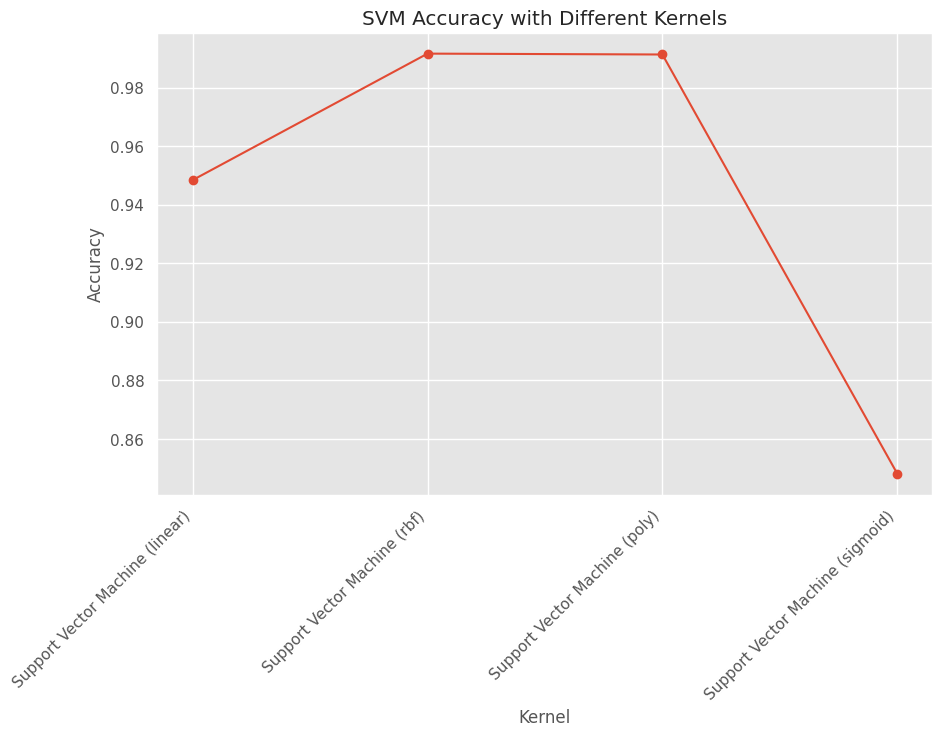

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(result_df['Model'], result_df['Accuracy'], marker='o')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy with Different Kernels')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

In [28]:
for svm_result in SVM_details:
  if svm_result['Accuracy'] > 0.9:
    model_details.append(svm_result)

In [29]:
SVM_details1 = []

# Define a function to evaluate the SVM model
def evaluate_svm_model(kernel_type, x_train, x_test, y_train, y_test):
    # Instantiate and train the SVM model with the specified kernel
    svm_model = SVC(kernel=kernel_type)

    start_time = time.time()
    svm_model.fit(x_train, y_train)
    svm_training_time = time.time() - start_time

    # Make predictions
    svm_y_test_pred = svm_model.predict(x_test)

    # Generate the classification report for test data
    class_report = classification_report(y_test, svm_y_test_pred, output_dict=True)

    # Extract key metrics from the classification report
    test_precision = class_report['macro avg']['precision']
    test_recall = class_report['macro avg']['recall']
    test_f1 = class_report['macro avg']['f1-score']
    acc = accuracy_score(y_test, svm_y_test_pred)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, svm_y_test_pred)

    # Store the results in a dictionary
    svm_results = {
        'Model': f'Support Vector Machine ({kernel_type}) with PCA',  # Model name
        'Training Time (s)': round(svm_training_time, 4),            # Training time in seconds
        'Accuracy':round(acc,4),                                     # Accuracy on the test set
        'Test Precision': round(test_precision, 4),          # Test Precision Macro
        'Test Recall': round(test_recall, 4),                # Test Recall Macro
        'Test F1 Score': round(test_f1, 4),                  # Test F1 Score Macro
    }

    return svm_results

# List of kernel types to evaluate
kernel_types = ['linear', 'rbf', 'poly', 'sigmoid']

# Iterate over the kernel types and evaluate each SVM model
for kernel in kernel_types:
    results = evaluate_svm_model(kernel, X_train_pca, X_test_pca, Y_train_pca, Y_test)
    SVM_details1.append(results)

# Convert the results to a DataFrame for better visualization
result_df1 = pd.DataFrame(SVM_details)

# Display the results
print(result_df1)


                              Model  Training Time (s)  Accuracy  \
0   Support Vector Machine (linear)            97.0462    0.9484   
1      Support Vector Machine (rbf)            15.9519    0.9916   
2     Support Vector Machine (poly)            17.5183    0.9913   
3  Support Vector Machine (sigmoid)           109.6941    0.8481   

   Test Precision  Test Recall  Test F1 Score  
0          0.9501       0.9469         0.9481  
1          0.9915       0.9917         0.9916  
2          0.9911       0.9913         0.9912  
3          0.8475       0.8474         0.8474  


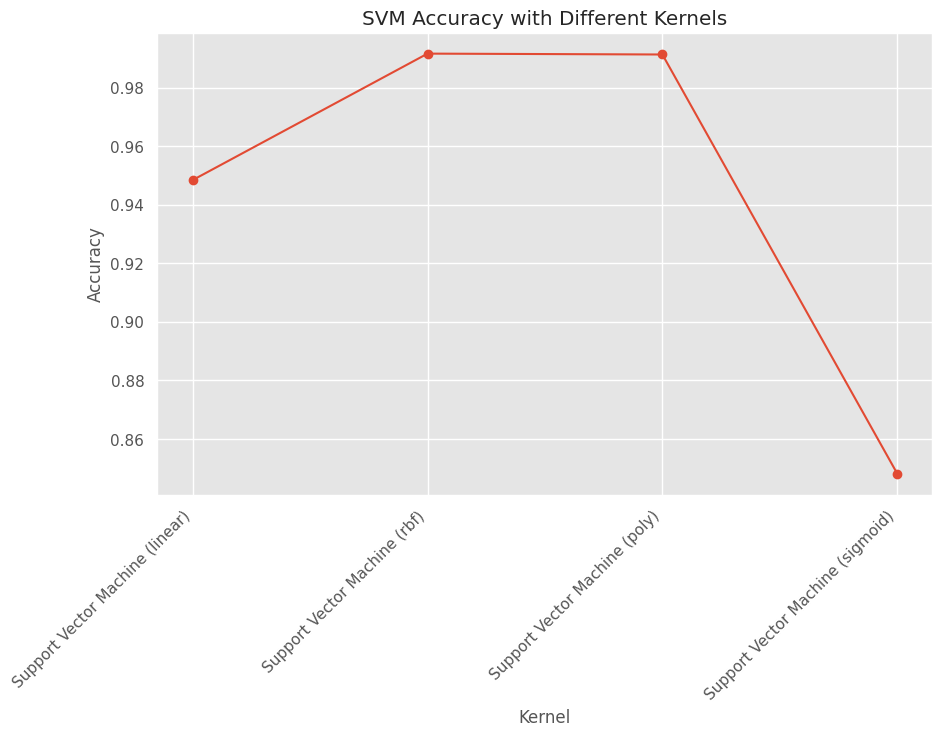

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(result_df['Model'], result_df1['Accuracy'], marker='o')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy with Different Kernels')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

In [31]:
for svm_result in SVM_details1:
  if svm_result['Accuracy'] > 0.9:
    model_details.append(svm_result)

## Ada Boost

In [32]:
def adaboost_tune(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100, log=False)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, step=0.01)

    classifier_obj = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)

    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

# Create a study and optimize
study_adaboost = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner())
study_adaboost.optimize(adaboost_tune, n_trials=30)

print(study_adaboost.best_trial)

# Train the final AdaBoost model with the best hyperparameters
ada_model = AdaBoostClassifier(
    n_estimators=study_adaboost.best_trial.params['n_estimators'],
    learning_rate=study_adaboost.best_trial.params['learning_rate']
)

# Measure training time
start_time = time.time()
ada_model.fit(x_train, y_train)
ada_training_time = time.time() - start_time

ada_y_test_pred=ada_model.predict(x_test)
class_report = classification_report(y_test, ada_y_test_pred, output_dict=True)

# Extract key metrics from the classification report
test_precision = class_report['macro avg']['precision']
test_recall = class_report['macro avg']['recall']
test_f1 = class_report['macro avg']['f1-score']
acc = accuracy_score(y_test, ada_y_test_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, ada_y_test_pred)

# Store the results
ada_results = {
    'Model': 'AdaBoost',
    'Training Time (s)': round(ada_training_time, 4),
    'Accuracy': round(acc, 4),
    'Test Precision': round(test_precision, 4),
    'Test Recall': round(test_recall, 4),
    'Test F1 Score': round(test_f1, 4),
}
# Display Results
print(f"\nTraining Time : {ada_training_time:.4f} seconds")
print("Classification Report :")
print(classification_report(y_test, ada_y_test_pred))
print("Confusion Matrix :")
print(conf_matrix)
print("Accuracy:",acc)

# Append the results to the list
model_details.append(ada_results)



FrozenTrial(number=11, state=TrialState.COMPLETE, values=[0.9914796782387807], datetime_start=datetime.datetime(2024, 11, 16, 7, 51, 45, 793867), datetime_complete=datetime.datetime(2024, 11, 16, 7, 51, 50, 183572), params={'n_estimators': 67, 'learning_rate': 0.9600000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=100, log=False, low=10, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=0.01)}, trial_id=11, value=None)

Training Time : 5.7048 seconds
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17710
           1       0.99      0.99      0.99     20082

    accuracy                           0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792

Confusion Matrix :
[[17511   199]
 [  123 19959]]
Accuracy: 0.9914796782387807


## XG Boost

In [33]:
def objective_xgboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300, log=False)
    max_depth = trial.suggest_int('max_depth', 3, 10, log=False)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01)

    classifier_obj = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, use_label_encoder=False, eval_metric='mlogloss')

    classifier_obj.fit(x_train, y_train)

    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

# Create a study and optimize
study_xgboost = optuna.create_study(direction='maximize')
study_xgboost.optimize(objective_xgboost, n_trials=30)

print(study_xgboost.best_trial)

# Train the final XGBoost model with the best hyperparameters
xgb_model = XGBClassifier(
    n_estimators=study_xgboost.best_trial.params['n_estimators'],
    max_depth=study_xgboost.best_trial.params['max_depth'],
    learning_rate=study_xgboost.best_trial.params['learning_rate'],
    use_label_encoder=False,
    eval_metric='mlogloss'
)

start_time = time.time()
xgb_model.fit(x_train, y_train)
xgb_training_time = time.time() - start_time

xgb_y_test_pred=xgb_model.predict(x_test)

# Generate the classification report for test data
class_report = classification_report(y_test, xgb_y_test_pred, output_dict=True)

# Extract key metrics from the classification report
test_precision = class_report['macro avg']['precision']
test_recall = class_report['macro avg']['recall']
test_f1 = class_report['macro avg']['f1-score']
acc = accuracy_score(y_test, xgb_y_test_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, xgb_y_test_pred)

# Store the results
xgb_results = {
    'Model': 'XG Boost',
    'Training Time (s)': round(xgb_training_time, 4),
    'Accuracy': round(acc, 4),
    'Test Precision': round(test_precision, 4),
    'Test Recall': round(test_recall, 4),
    'Test F1 Score': round(test_f1, 4),
}
# Display Results
print(f"\nTraining Time : {xgb_training_time:.4f} seconds")
print("Classification Report :")
print(classification_report(y_test, ada_y_test_pred))
print("Confusion Matrix :")
print(conf_matrix)
print("Accuracy:",acc)

# Append the results to the list
model_details.append(xgb_results)


FrozenTrial(number=19, state=TrialState.COMPLETE, values=[0.9991003386960203], datetime_start=datetime.datetime(2024, 11, 16, 7, 54, 1, 334553), datetime_complete=datetime.datetime(2024, 11, 16, 7, 54, 2, 756256), params={'n_estimators': 234, 'max_depth': 4, 'learning_rate': 0.23}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=0.01)}, trial_id=19, value=None)

Training Time : 1.3540 seconds
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17710
           1       0.99      0.99      0.99     20082

    accuracy                           0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792

Confusion Matrix :
[[176

## SKLearn Gradient Boosting

In [34]:
# Define the objective function for Optuna to optimize Gradient Boosting hyperparameters
def objective_gradientboosting(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300, log=False)
    max_depth = trial.suggest_int('max_depth', 3, 10, log=False)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01)

    classifier_obj = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

    classifier_obj.fit(x_train, y_train)

    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

# Create a study and optimize
study_gradientboosting = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner())
study_gradientboosting.optimize(objective_gradientboosting, n_trials=10)

print(study_gradientboosting.best_trial)

# Train the final Gradient Boosting model with the best hyperparameters
gb_model = GradientBoostingClassifier(
    n_estimators=study_gradientboosting.best_trial.params['n_estimators'],
    max_depth=study_gradientboosting.best_trial.params['max_depth'],
    learning_rate=study_gradientboosting.best_trial.params['learning_rate']
)

start_time = time.time()
gb_model.fit(x_train, y_train)
gb_training_time = time.time() - start_time

gb_y_test_pred = gb_model.predict(x_test)

# Generate the classification report for test data
class_report = classification_report(y_test, gb_y_test_pred, output_dict=True)

# Extract key metrics from the classification report
test_precision = class_report['macro avg']['precision']
test_recall = class_report['macro avg']['recall']
test_f1 = class_report['macro avg']['f1-score']
acc = accuracy_score(y_test, gb_y_test_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, gb_y_test_pred)

# Store the results
gb_results = {
    'Model': 'Gradient Boosting',
    'Training Time (s)': round(gb_training_time, 4),
    'Accuracy': round(acc, 4),
    'Test Precision': round(test_precision, 4),
    'Test Recall': round(test_recall, 4),
    'Test F1 Score': round(test_f1, 4),
}
# Display Results
print(f"\nTraining Time : {gb_training_time:.4f} seconds")
print("Classification Report :")
print(classification_report(y_test, gb_y_test_pred))
print("Confusion Matrix :")
print(conf_matrix)
print("Accuracy:", acc)

# Append the results to the list
model_details.append(gb_results)

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9992061812023709], datetime_start=datetime.datetime(2024, 11, 16, 7, 54, 20, 622046), datetime_complete=datetime.datetime(2024, 11, 16, 7, 55, 35, 56089), params={'n_estimators': 263, 'max_depth': 6, 'learning_rate': 0.19}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=0.01)}, trial_id=0, value=None)

Training Time : 73.6159 seconds
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17710
           1       1.00      1.00      1.00     20082

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

Confusion Matrix :
[[176

## Naive Bayes


In [35]:
naive_bayes_details = []

def evaluate_naive_bayes(model_type, x_train, y_train, x_test, y_test):
    if model_type == 'GaussianNB':
        model = GaussianNB()
    elif model_type == 'BernoulliNB':
        model = BernoulliNB()
    else:
        return None  # Handle invalid model type

    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time

    y_test_pred = model.predict(x_test)

    class_report = classification_report(y_test, y_test_pred, output_dict=True)

    test_precision = class_report['macro avg']['precision']
    test_recall = class_report['macro avg']['recall']
    test_f1 = class_report['macro avg']['f1-score']
    acc = accuracy_score(y_test, y_test_pred)

    conf_matrix = confusion_matrix(y_test, y_test_pred)

    results = {
        'Model': f'{model_type}',
        'Training Time (s)': round(training_time, 4),
        'Accuracy': round(acc, 4),
        'Test Precision': round(test_precision, 4),
        'Test Recall': round(test_recall, 4),
        'Test F1 Score': round(test_f1, 4),
    }
    return results

model_types = ['GaussianNB', 'BernoulliNB']  # Explore Gaussian and Bernoulli Naive Bayes

for model_type in model_types:
    results = evaluate_naive_bayes(model_type, x_train, y_train, x_test, y_test)
    if results:
        naive_bayes_details.append(results)
        if results['Accuracy'] > 0.9:
            model_details.append(results)


# Evaluate Naive Bayes with PCA
for model_type in model_types:
    results = evaluate_naive_bayes(model_type, X_train_pca, Y_train_pca, X_test_pca, Y_test)
    if results:
        results['Model'] = f'{model_type} with PCA'
        naive_bayes_details.append(results)
        if results['Accuracy'] > 0.9:
            model_details.append(results)

print(pd.DataFrame(naive_bayes_details))

                  Model  Training Time (s)  Accuracy  Test Precision  \
0            GaussianNB             0.0522    0.9104          0.9134   
1           BernoulliNB             0.0499    0.9007          0.9074   
2   GaussianNB with PCA             0.1021    0.5482          0.6817   
3  BernoulliNB with PCA             0.0995    0.8725          0.8720   

   Test Recall  Test F1 Score  
0       0.9078         0.9095  
1       0.8969         0.8993  
2       0.5715         0.4809  
3       0.8732         0.8723  


# Summary


Why Training Time Matters:

    While accuracy is the primary goal in model selection, training time is also crucial.
    Shorter training times mean:

    1. Faster Development Cycles: Experimenting and iterating on models becomes quicker.
    2. Reduced Resource Consumption: Less computational resources are used during training, which can be costly in cloud environments or with limited hardware.
    3. Faster Deployment: Once a model is trained, deploying it to production becomes more efficient if the training process was faster.

    Therefore, even though accuracy is top priority, it's important to consider the training time, especially when several models achieve comparable accuracy.
    Choosing a model with a slightly lower accuracy but significantly faster training time can sometimes be a more practical solution, especially when resources are limited or deployment speed is important.
  

Model Summary Report:
                                       Model  Training Time (s)  Accuracy  \
0                                        KNN             0.0040    0.9957   
1                        Logistic Regression             0.0040    0.9414   
2                              Decision Tree             0.1585    0.9976   
3                        Decision Tree (PCA)             1.7506    0.9943   
4                              Random Forest             2.1267    0.9988   
5                        Random Forest (PCA)            10.8199    0.9966   
6            Support Vector Machine (linear)            97.0462    0.9484   
7               Support Vector Machine (rbf)            15.9519    0.9916   
8              Support Vector Machine (poly)            17.5183    0.9913   
9   Support Vector Machine (linear) with PCA           159.4960    0.9576   
10     Support Vector Machine (rbf) with PCA            32.4362    0.9912   
11    Support Vector Machine (poly) with PCA          

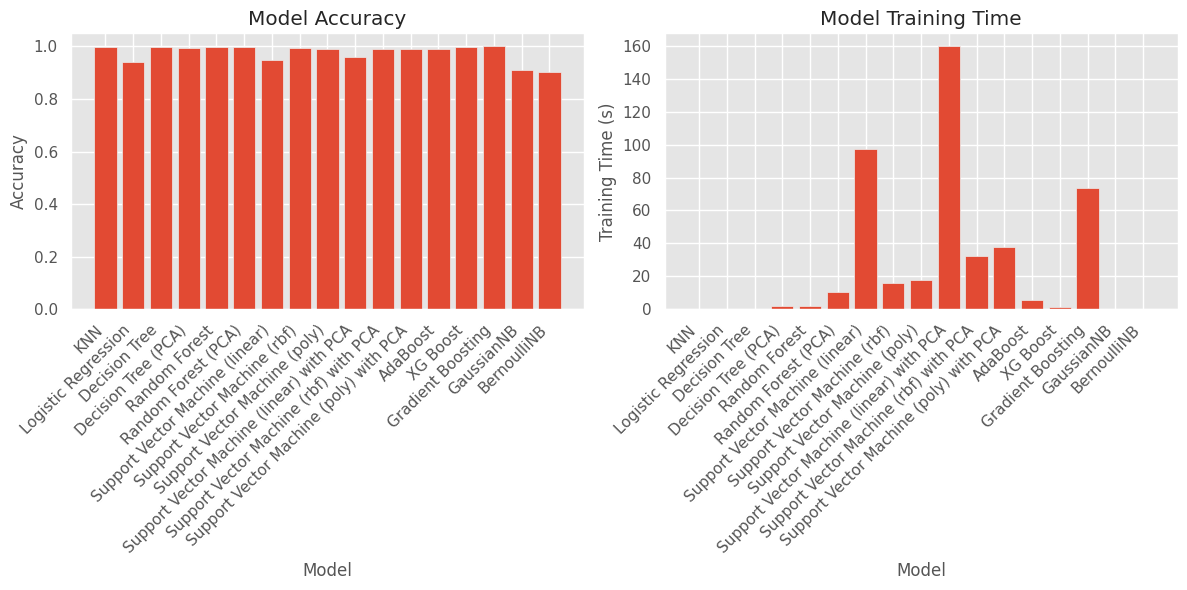

Top 3 Models based on Accuracy (considering minimal training time):
                Model  Training Time (s)  Accuracy  Test Precision  \
14  Gradient Boosting            73.6159    0.9992          0.9992   
13           XG Boost             1.3540    0.9991          0.9991   
4       Random Forest             2.1267    0.9988          0.9988   

    Test Recall  Test F1 Score  
14       0.9992         0.9992  
13       0.9991         0.9991  
4        0.9987         0.9988  


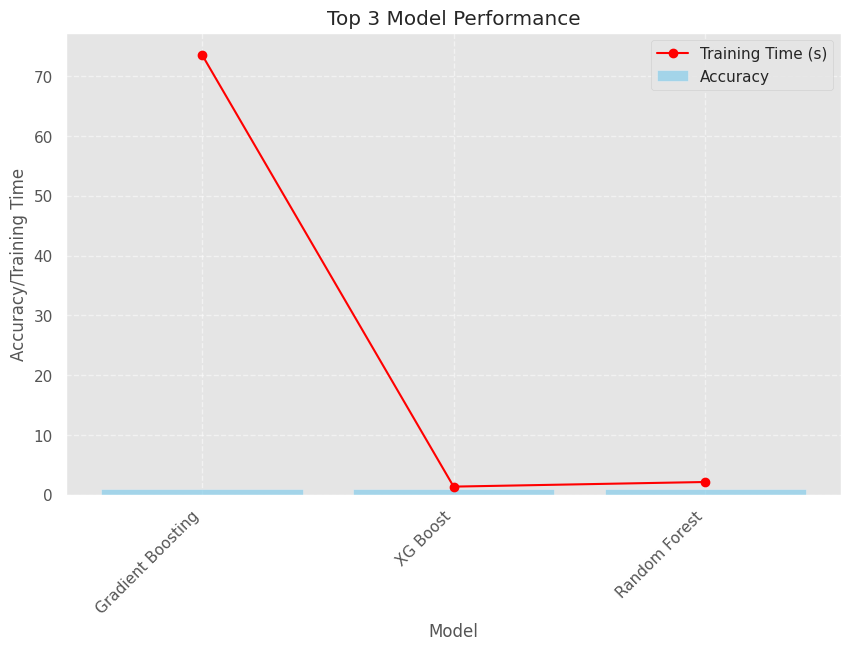

In [36]:
df_model_details = pd.DataFrame(model_details)

# Generate a summary report
print("Model Summary Report:")
print(df_model_details)

# Generate a graph of accuracy and training time
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.bar(df_model_details['Model'], df_model_details['Accuracy'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(rotation=45, ha='right')

# Plot training time
plt.subplot(1, 2, 2)
plt.bar(df_model_details['Model'], df_model_details['Training Time (s)'])
plt.xlabel('Model')
plt.ylabel('Training Time (s)')
plt.title('Model Training Time')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

df_sorted = df_model_details.sort_values(['Accuracy', 'Training Time (s)'], ascending=[False, True])

# Get the top 3 models
top_3_models = df_sorted.head(3)

print("Top 3 Models based on Accuracy (considering minimal training time):")
print(top_3_models)

# Plot Accuracy and Training Time for the top 3 models
plt.figure(figsize=(10, 6))
# Create a bar chart for Accuracy with transparent background
plt.bar(top_3_models['Model'], top_3_models['Accuracy'], color='skyblue', alpha=0.7, label='Accuracy')
# Create a line plot for Training Time
plt.plot(top_3_models['Model'], top_3_models['Training Time (s)'], marker='o', color='red', label='Training Time (s)')
plt.xlabel('Model')
plt.ylabel('Accuracy/Training Time')
plt.title('Top 3 Model Performance')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



In [39]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

model1 = gb_model
model2 = xgb_model
model3 = rf
# Create a pipeline with a voting classifier combining the top 3 models
pipeline = Pipeline([
    ('voting_classifier', VotingClassifier(estimators=[
        ('model1', model1),
        ('model2', model2),
        ('model3', model3)
    ], voting='soft'))
])

# Train the pipeline
pipeline.fit(x_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(x_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17710
           1       1.00      1.00      1.00     20082

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



In [40]:
#Accuracy
acc = accuracy_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(acc)
print(conf_matrix)

0.9991532599491956
[[17689    21]
 [   11 20071]]


In [41]:
import joblib
joblib.dump(pipeline, 'intrusionDetection_model.pkl')

['intrusionDetection_model.pkl']